# INF8775 – Analyse et conception d’algorithmes
# TP3 – Automne 2024

Côté, Gabriel, 2082508

Tourigny, François, 2079718

Note finale:

<u>**Date limite de remise :**</u>  4 décembre 23h59 pour les deux groupes

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte.

- Vous pouvez utiliser des fichiers externes pour stocker des exemplaires et des résultats, mais nous devons être capable de comprendre facilement votre démarche et de la reproduire.

- <u>**IMPORTANT**</u> Remettez le fichier du notebook sur Moodle avec le nom `MATRICULE1_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et est une occasion de mettre en application les connaissances vues en cours. Vous devrez développer l'algorithme de votre choix pour essayer de résoudre le plus efficacement possible le problème donné. Une partie de la note sera accordée en fonction des résultats que vous obtiendrez par rapport aux autres équipes.

## Description du problème

Le problème qu'on vous demande de résoudre cette fois-ci est un peu plus difficile. Vous êtes responsable de la séparation des voteurs d'un pays en circonscriptions. Un des deux candidats principaux, M. T, vient vous voir et vous demande de lui garantir une victoire (pour un montant non négligeable d'argent). Évidemment, vous refusez, mais le problème est intéressant et vous décidez d'essayez de le résoudre. Si ça vous intéresse, ce problème est ce qu'on appelle du *gerrymandering*.

Vous aurez comme entrée à votre problème une carte du pays (représentée par une matrice carrée $n \times n$) qui contient à chaque position le nombre de voteurs pour candidat X (un chiffre entre 0 et 1000). Votre objectif est de créer $n$ circonscriptions de sorte à ce que candidat X gagne l'élection. Quelques spécifications importantes:

- La variable $n$ représente un côté de la matrice. Il y a donc, $n^2$ villes.
- Chaque position de la matrice représente une ville
- Chaque circonscription doit contenir **$n$ villes**. Une solution reste valide si une circonscription ne contient pas exactement $n$ villes, mais il y a une **pénalité** qui y est associée.
- Les villes d'une circonscription doivent être proche les unes des autres. On aimerait garder cette **distance à, au plus, $n/2$**. Encore une fois, on permet de briser cette contrainte, mais il y aura une pénalité qui y est associée. (**Distance manhattan**)
- Les villes d'une circonscription ne doivent **pas être nécessairement voisines** tant qu'on respecte la distance maximale. Voir l'exemple plus bas.
- Le candidat remporte une circonscription si le nombre de voteurs dans cette circonscription est supérieur à $500n$.
- Le candidat cherche à remporter le plus de circonscriptions qu'il peut.

![alt text](distance_example.png)


## Jeu de données

La classe Problem existe pour simplifier l'interface des différentes fonctions utilitaires. Elle permet de générer des jeux de données avec la méthode `generate_sample` ci-dessous. Elle génère une matrice carrée de taille $n$ contenant des nombres entre $1$ et $1000$. Vous pouvez utilisez des exemplaires aléatoires pour tester votre code. La compétition sera faite sur les mêmes exemplaires de tailles différentes pour toutes les équipes d'un même groupe.

In [83]:
import random
from collections.abc import Iterable

def generate_city() -> int:
    return round(min(1000,max(0,random.normalvariate(450,200))))

class Problem():
    def __init__(self, size: int, num_samples: int = 5) -> None:
        self.size = size
        self.num_samples = num_samples

    def generate_sample(self) -> list[list[int]]:
        """Returns a matrix containing values between 0 and 1000. Each value is the number of voters in a given city"""
        return [[generate_city() for _ in range(self.size)] for _ in range(self.size)]

    def generate_dataset(self) -> Iterable[list[list[int]]]:
        """Returns an iterator over as many samples as are described"""
        return (self.generate_sample() for _ in range(self.num_samples))

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [84]:
import matplotlib.pyplot as plt
import time
from collections.abc import Callable
from math import ceil
import math
from scipy.stats import linregress
import numpy as np
from tqdm import trange

class InvalidSolution(Exception):
    def __init__(self):
        super().__init__("Invalid solution, verify your code.")

class Measure():
    """A wrapper to contain information on taken measures"""
    def __init__(self, size: int, mean: int, score:int) -> None:
        self.size = size
        self.mean_score = score
        self.mean = mean

def score_solution(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> int:
    """Returns the score of the current solution. The score function is a penalty that must be minimized."""
    return votes_score(original, solution) + size_score(solution) + distance_score(solution)

def votes_score(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to lost districts. 
    It is 5 times the square of the number of lost districts."""
    lost_districts = 0
    for district in solution:
        sum = 0
        for city in district:
            sum += original[city[0]][city[1]]
        if sum <= 500*len(district):
            lost_districts += 1
    return 5 * lost_districts**2

def size_score(solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to districts having the wrong size.
    It is the square of the difference between the wanted number of cities and the 
    current number of cities in a given district."""
    n = len(solution)
    size_penality = 0
    for district in solution:
        size_penality += (len(district)-n)**2
    return size_penality

def distance_score(solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to the distance between cities in a district.
    It is the mean square distance between each city and every other city in its district."""
    distance_score = 0
    n = len(solution)
    for district in solution:
        for i,city in enumerate(district):
            for j in range(i+1, len(district)):
                distance_score += (max(0, distance_manhattan(city, district[j])-ceil(n/2)))**2
    return distance_score/len(solution)

def distance_manhattan(city_a: tuple[int,int], city_b: tuple[int,int]) -> int:
    return abs(city_a[0] - city_b[0]) + abs(city_a[1] - city_b[1])

def is_valid_solution(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> bool:
    """Validates solution"""
    n = len(original)

    if len(solution) != n:
        print(f"The solution does not contain {n} districts.")
        return False

    for district in solution:
        if len(district) < 1:
            print("The solution contains empty districts.")
            return False
        for city in district:
            if len(city)!=2:
                print("Solution must contain 2 coordinates per city.")
                return False
        for coord in city:
            if coord < 0 or coord >=n:
                print(f"City coordinates must below {n} and positive.")
                return False

    coord_set = set()
    for district in solution:
        for city in district:
            coord_set.add(city)
    if len(coord_set) != n*n:
        print(f"Solution contained {len(coord_set)} different cities while there should be {n*n} cities in the solution.")
        return False

    # Solution is valid
    return True

def make_problems(sizes: list[int], num_samples: int = 5) -> list[Problem]:
    """Creates problem instances using given sizes and max_numbers"""
    return [Problem(size,num_samples) for size in sizes]

def measure(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], sample: list[list[int]], time_scale: int = 1000) -> tuple[int,int]:
    """Returns a tuple containing the time as well as the score of the solution, in that order.
    
    Parameters:
        time_scale: Controls the level of precision of the time measurements.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * time_scale
    solution: list[int] = procedure(sample)
    end: int = time.time() * time_scale
    if not is_valid_solution(sample, solution):
        raise InvalidSolution()
    return (round(end - start), score_solution(sample, solution))

def measure_mean(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], prob: Problem, time_scale: int = 1000) -> Measure:
    """Generates multiple samples with the specified parameters and returns a Measure 
    instance representing the result as well as the problem.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    results = [measure(procedure,sample,time_scale) for sample in prob.generate_dataset()]
    mean_time = sum(result[0] for result in results) / prob.num_samples
    mean_score = sum(result[1] for result in results) / prob.num_samples
    return Measure(prob.size, mean_time, mean_score)

def measure_range(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], problems: list[Problem], time_scale: int = 1000) -> list[Measure]:
    """Measures the mean time taken for each problem in the given list.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.

    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time and the score.
    """
    return [
        measure_mean(procedure, prob, time_scale)
        for prob in problems
    ]

def display_data_as_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <12} {: <12} {: <12}".format("Taille", "Temps moyen", "Score moyen"))
    for measure in measures:
        print("{: <12} {: <12} {: <12}".format(measure.size, measure.mean, measure.mean_score))

### The different tests are below, the names are in french to avoid confusion

def test_de_puissance(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de puissance"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    # Log both sets of values
    x = list(data.keys())
    y = list(data.values())

    # Perform the lin regression
    m, b, rvalue, _, _ = linregress(x, y)

    # Estimate the values of y based on the lin regression results
    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def test_de_rapport(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de rapport"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

def test_de_constantes(
    data: dict[int,int],
    x_label: str,
    y_label: str = "Temps (ms)",
    title: str = "Test de constantes"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

# Algorithme

Votre algorithme sera en partie noté en fonction d'une évaluation relative entre les équipes. 4 points seront donnés aux équipes qui se classeront dans le premier quartile lors de notre évaluation sur un ensemble d'exemplaires. Les équipes se trouvant dans le quartile dont les algorithmes ont le moins bien performé recevront 1 point.

**IMPORTANT** Votre algo doit retourner une solution après 3 minutes. Si ce n'est pas le cas, vous serez pénalisé.

In [85]:
class County():
    def __init__(self, row: int, col: int, pos: int, voters: int) -> None:
        self.row = row
        self.col = col
        self.pos = pos
        self.voters = voters
        self.neighbors = []
        self.group = -1

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)

    def get_neighbours(self):
        return self.neighbors
    
    def set_group(self, group: int):
        self.group = group
    
    def get_group(self):
        return self.group
    
    def is_in_group(self):
        return self.group != -1


In [86]:
def get_neighbours_idx(idx, n):
    neighbours = []
    if idx - n > 0:
        neighbours.append(idx-n)
    if idx + n < n**2:
        neighbours.append(idx+n)
    if idx // n == (idx-1) // n:
        neighbours.append(idx-1)
    if idx // n == (idx+1) // n:
        neighbours.append(idx+1)
    return neighbours

def set_counties(sample) -> list[County]:
    n = len(sample)
    counties = [County(i, j, i*n+j, county) for i, line in enumerate(sample) for j, county in enumerate(line)]
    for county in counties:
        for neighbor_idx in get_neighbours_idx(county.pos, n):
            county.add_neighbor(counties[neighbor_idx])
    return counties


In [87]:
def distance(county_row, county_col, center_row, center_col, n):
    return (abs(center_row - county_row) + abs(center_col - county_col))
    
def max_to_target(counties: list[County], target: int, n: int):
    solution = []
    counties_available = counties
    groups = []
    groups_center = []
    center_row = 0
    center_col = 0
    for group_id in trange(n):
        new_group = []
        number_items = 0
        center_row = 0
        center_col = 0
        group_neighbors = []
        while len(new_group) < n:
            selection = None
            if len(group_neighbors) == 0:
                selection = max(counties_available, key=lambda county: county.voters/n - distance(county.row, county.col, center_row, center_col, n)**2/n)
            elif sum(county.voters for county in new_group) < target:
                selection = max(group_neighbors, key=lambda county: county.voters/n - distance(county.row, county.col, center_row, center_col, n)**2/n)
                #selection = random.choice(group_neighbors)
            else:
                selection = min(group_neighbors, key=lambda county: county.voters/n + distance(county.row, county.col, center_row, center_col, n)**2/n)

            new_group.append(selection)
            center_row = (center_row * number_items + selection.row) / (number_items + 1)
            center_col = (center_col * number_items + selection.col) / (number_items + 1)
            number_items += 1
            selection.set_group(group_id)
            
            group_neighbors.extend([neighbor for neighbor in selection.neighbors if not neighbor.is_in_group() and not neighbor in group_neighbors])
            counties_available.remove(selection)
            if selection in group_neighbors:
                group_neighbors.remove(selection)
            
        groups.append(new_group)
        groups_center.append((center_row, center_col))
        solution.append([(county.row, county.col) for county in new_group])
    return solution, groups



In [88]:

def main(sample):
    start_time = time.time()
    max_time = 60 * 3 - 1
    n = len(sample)
    target = 500 * n
    counties = set_counties(sample)
    print('initial solution')
    sol, groups = max_to_target(counties, target, n)
    if (time.time() - start_time) > max_time:
        return sol
    print("--- %s seconds for solution baseline ---" % (time.time() - start_time))

    #print('vote score: ', votes_score(sample, sol))
    #print('size score: ', size_score(sol))
    #print('distance score: ', distance_score(sol))
    #print('intial score: ',score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    first_iter = True
    iter_time = time.time()
    time_to_iter = 0
    print('improvement')
    while(True):
        updated = amelioration_locale(groups, target, n, sample, sol)
        sol = updated

        if (time.time() - start_time) > max_time - time_to_iter:
            return sol
        if(first_iter):
            first_iter = False
            time_to_iter = (time.time() - iter_time)

    #print(" ---------------- AFTER UPDATE -----------------")
    #print('vote score: ', votes_score(sample, sol))
    #print('size score: ', size_score(sol))
    #print('distance score: ', distance_score(sol))
    #print('total score: ', score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    return sol


def amelioration_locale(divisions, target, n, sample, sol):
    #init_score = score_solution(sample, sol)
    div_votes = [sum(county.voters for county in div) for div in divisions]
    groups_center = [(sum(county.row for county in div)/n, sum(county.col for county in div)/n) for div in divisions]

    #selected_div_idx = div_votes.index(max(div for div in div_votes if div < target))
    #selected_div_idx = divisions.index(random.choice([div for div in divisions if sum(county.voters for county in div) < target]))
    selected_div_idx = divisions.index(random.choice(divisions))
    #selected_div_idx = div_votes.index(min(div_votes))

    selected_div = divisions[selected_div_idx]
    center_swap_group_row = groups_center[selected_div_idx][0]
    center_swap_group_col = groups_center[selected_div_idx][1]

    modified_selected_div = [county.voters + distance(center_swap_group_row, center_swap_group_col, county.row, county.col, n) for county in selected_div]
    county_to_swap_idx = modified_selected_div.index(min(modified_selected_div))
    county_to_swap = divisions[selected_div_idx][county_to_swap_idx]
    #print('county to swap: ', county_to_swap.pos)
    differential_needed = target - county_to_swap.voters
    distance_div_swap = distance(center_swap_group_row, center_swap_group_col, county_to_swap.row, county_to_swap.col, n)

    swap_scores = {}
    for div_idx in range(len(divisions)):
        if div_idx == selected_div_idx:
            continue

        votes_to_spare = div_votes[div_idx] - target
        if votes_to_spare <= 0:
            votes_to_spare = target
        
        div_center_row = groups_center[div_idx][0]
        div_center_col = groups_center[div_idx][1]
        distance_div_swap_new_group = distance(div_center_row, div_center_col, county_to_swap.row, county_to_swap.col, n)

        for county_idx, county in enumerate(divisions[div_idx]):
            if county.voters - county_to_swap.voters > votes_to_spare:
                continue
            dist_county_curr_group = distance(div_center_row, div_center_col, county.row, county.col, n)
            dist_county_swap_group = distance(center_swap_group_row, center_swap_group_col, county.row, county.col, n)
            score_voters =  (county.voters/n - county_to_swap.voters/n) + (0 if county.voters - county_to_swap.voters < differential_needed else target)
            score_distance = (dist_county_curr_group + distance_div_swap) - (dist_county_swap_group + distance_div_swap_new_group)
            swap_scores[county.pos] = score_voters + n * score_distance

    #print(swap_scores)
    if len(swap_scores) == 0:
        return sol
    switch_county_pos = max(swap_scores, key=swap_scores.get)
    if swap_scores[switch_county_pos] < 0:
        return sol
    #print(switch_county_pos)
    switch_county_row = switch_county_pos // n
    switch_county_col = switch_county_pos % n

    div_switch_idx = -1
    pos_pair_switch = (switch_county_row, switch_county_col)
    for div_idx in range(len(divisions)):
        if pos_pair_switch in sol[div_idx]:
            div_switch_idx = div_idx
    
    #update solution
    sol[div_switch_idx].remove(pos_pair_switch)
    sol[div_switch_idx].append((county_to_swap.row, county_to_swap.col))

    sol[selected_div_idx].append(pos_pair_switch)
    sol[selected_div_idx].remove((county_to_swap.row, county_to_swap.col))

    #update divisions
    divisions[selected_div_idx].remove(county_to_swap)
    pos_arr = [div.pos for div in divisions[div_switch_idx]]

    idx_select = pos_arr.index(switch_county_pos)
    switch = divisions[div_switch_idx][idx_select]
    divisions[selected_div_idx].append(switch)

    divisions[div_switch_idx].append(county_to_swap)
    divisions[div_switch_idx].remove(switch)

    #print('new score: ',score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    return sol
    




In [89]:
resultats = measure_range(main, make_problems([100], 1) )

display_data_as_table(resultats)

initial solution


100%|██████████| 100/100 [00:02<00:00, 41.50it/s]


--- 2.444875478744507 seconds for solution baseline ---
improvement


KeyboardInterrupt: 

In [ ]:
def drawmap_of_discrits(n, discrits: list[list[tuple[int,int]]]):
    colors = [[0 for _ in range(n)] for _ in range(n)]
    for i,district in enumerate(discrits):
        for city in district:
            colors[city[0]][city[1]] = i+1

    plt.imshow(colors, cmap='tab20')
    plt.show()


# Analyse asymptotique

Notre algorithme se sépare en 3 grande sections. La première d'entre elle est la création des objets County avoir leur voisinage. La seconde section est la génération d'une séparation initiale et la dernière partie est une amélioration locale.

# Création des County
Commençons par la création des County. La création se sépare en 2 phases, la première est de créer chaque County qui se fait en temps constant pour les n² éléments donc ceci nous donne theta(n²). La seconde étape de création est de passer par chacun des County créés et placer leur voisins qui sont au nombre maximal de 4 donc nous avons une complexité de theta(4*n²) qui est dans le même ordre de grandeur que theta(n²). Bref, la création des objets County se fait en theta(n² + n²) ce qui veut dire une complexité de theta(n²).

# Séparation initiale
La deuxième portion de notre algorithme est un algorithme glouton qui fait une répartion des County en n groupes. Dans chacun des n groupes, on fait n fois la recherche d'un prochain élément. Dans cette recherche de prochain élément, nous avons 2 choix qui sont de faire une rechreche parmis les voisins s'il y en a et sinon parmis tout les County qui ne sont pas déjà choisis dans un groupe. Dans le pire des cas, nous avons n² choix pour notre recherche de la valeur maximale. Ce qui nous donne une complexité de theta(n\*n\*n²) ceci équivaut à une complexité de theta(n⁴).

# Amélioration locale
La dernière partie est une amélioration locale. L'amélioration se fait en plusieurs sections successives. La première de ces sections de l'amélioration locale est de calculer le centre du groupe nous avons n appels de la distance pour chacun des n groupes ce qui fait au total n² appels de la distance qui est un calcul en temps constant. Cette première partie de l'amélioration locale est donc en theta(n²\*1) donc theta(n²).
La seconde partie de l'amélioration locale est la sélection d'un County à échanger qui est en theta(n) pour le choix du groupe dans lequel prendre le County à échanger puis de theta(n) pour choisir le County parmis le groupe choisi. Ceci nous theta(n+n) donc theta(n) pour la sélection du County à échanger. Nous devons ensuite sélectionner le County avec lequel le premier chois sera échangé. Pour tous les County qui ne sont pas dans le groupe initial, nous générons un score de préférence pour faire l'échange avec le County choisi initialement. Ce calcul de score est en temps constant pour les au maximum n² County possibles pour faire un échange. Bref, le choix du second County pour l'échange se fait en theta(n²\*1) ce qui donne theta(n²).
Finalement, pour l'amélioration locale, nous avons l'échange des deux éléments qui se fait en temps constant theta(1).
Notre section d'amélioration locale se fait donc avec la complexité suivante theta(n²+n²+1) ce qui nous donne theta(n²)
La section d'amélioration locale est exécutée tant que du temps est disponible (avec une marge de sureté), mais ultimement le nombre d'exécutions peut être comme indépendant de n.

# Algorithme complet
Pour notre algorithme complet, nous pouvons additionner la complexité théorique de nos sections, car elle sont exécutées l'une à la suite de l'autre.
Nous avons donc theta(n²+n⁴+n²) ce qui nous donne une complexitée finale de theta(n⁴)

# Analyse hybride


PAS faire le test de constante (pour deux variable et on a pas)
Faire le test de puissance (faire en log log comme échelle) On devrait voir la valeur 4x
On peut utiliser un test de rapport pour confirmer le test de puissance
Faire le test de rapport en dernier si tout fonctionne


Expliquer l'utilisation de chacun des graphiques, expliquer en quoi le graphique justifie la complexité et pourquoi ne pas utiliser certain graphiques.

Effectuer une analyse hybride de votre algorithme.

In [ ]:
problems = make_problems([x for x in range(11, 61)], 10)

In [112]:
# On réécris certaines fonctions pour pouvoir les évaluer individuellement sans contrainte de temps maximum

def main_greedy(sample):
    start_time = time.time()
    n = len(sample)
    target = 500 * n
    counties = set_counties(sample)
    print('initial solution')
    sol, groups = max_to_target(counties, target, n)
    print("--- %s seconds for solution baseline ---" % (time.time() - start_time))
    return sol
    

### Génération de moyennes

Ici on génère les moyennes de temps et de score pour chaque grandeur de n. On calcule à partir de n = 11 pour éviter le plus possible les problèmes de temps moyen inconsistant quand notre n est très petit. Pour plus de stabilité, nous faisons 10 runs par grandeur de n, pour au total 50 valeurs de n.

In [ ]:
resultats_greedy = measure_range(main_greedy, problems)

display_data_as_table(resultats_greedy)


initial solution


100%|██████████| 11/11 [00:00<00:00, 5398.71it/s]


--- 0.14529705047607422 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 5495.81it/s]


--- 0.004001617431640625 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 10935.61it/s]


--- 0.0045735836029052734 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 5499.74it/s]


--- 0.0040018558502197266 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 2693.52it/s]


--- 0.00609278678894043 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 7489.83it/s]


--- 0.00451350212097168 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 10938.20it/s]


--- 0.004577159881591797 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 4135.65it/s]


--- 0.005678892135620117 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 5043.99it/s]


--- 0.005185842514038086 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 5470.40it/s]


--- 0.005010843276977539 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 12041.06it/s]


--- 0.005002021789550781 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 4886.57it/s]


--- 0.0054781436920166016 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 7442.21it/s]


--- 0.0056247711181640625 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 6016.21it/s]


--- 0.005999565124511719 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 5735.80it/s]


--- 0.005099773406982422 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 12041.06it/s]


--- 0.0047757625579833984 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 5980.47it/s]


--- 0.003525972366333008 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 6011.18it/s]


--- 0.006165266036987305 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 5939.54it/s]


--- 0.005365848541259766 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 11828.82it/s]


--- 0.00419306755065918 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 5384.75it/s]


--- 0.005423307418823242 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6479.61it/s]


--- 0.006008148193359375 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4760.43it/s]


--- 0.0047283172607421875 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6507.45it/s]


--- 0.004998207092285156 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 5955.22it/s]


--- 0.005849123001098633 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 5876.27it/s]


--- 0.004315376281738281 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6502.80it/s]


--- 0.006006002426147461 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6512.12it/s]


--- 0.006184101104736328 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6506.68it/s]


--- 0.006001472473144531 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6509.01it/s]


--- 0.0050008296966552734 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 5541.22it/s]


--- 0.006078004837036133 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 3820.45it/s]


--- 0.005285739898681641 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 4077.51it/s]


--- 0.006858110427856445 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 7005.52it/s]


--- 0.005385398864746094 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 4099.43it/s]


--- 0.0064237117767333984 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 3998.38it/s]


--- 0.005538225173950195 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 5855.63it/s]


--- 0.0054187774658203125 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 4650.00it/s]


--- 0.006098747253417969 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 5641.30it/s]


--- 0.0044879913330078125 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 5629.94it/s]


--- 0.0056285858154296875 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4808.88it/s]


--- 0.00567317008972168 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4710.58it/s]


--- 0.008104562759399414 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 3736.68it/s]


--- 0.006271839141845703 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4977.81it/s]


--- 0.007126808166503906 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4595.32it/s]


--- 0.006480216979980469 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 5006.73it/s]


--- 0.008033514022827148 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4989.26it/s]


--- 0.007058620452880859 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 2688.08it/s]


--- 0.008645296096801758 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 3737.79it/s]


--- 0.008010387420654297 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 3631.43it/s]


--- 0.006258249282836914 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3992.67it/s]


--- 0.00883340835571289 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 4003.87it/s]


--- 0.008495330810546875 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 4689.65it/s]


--- 0.008957147598266602 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3861.05it/s]


--- 0.007459878921508789 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3631.83it/s]


--- 0.008931636810302734 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 2160.97it/s]

--- 0.010424137115478516 seconds for solution baseline ---
initial solution



100%|██████████| 16/16 [00:00<00:00, 1999.61it/s]


--- 0.013429880142211914 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 4004.35it/s]


--- 0.010012149810791016 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3782.27it/s]


--- 0.010368585586547852 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 4513.95it/s]


--- 0.007554531097412109 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3180.20it/s]


--- 0.00938558578491211 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3330.52it/s]


--- 0.009283304214477539 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3395.39it/s]


--- 0.008277654647827148 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 2293.96it/s]


--- 0.013691902160644531 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3710.61it/s]


--- 0.008706092834472656 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 2965.04it/s]

--- 0.009875059127807617 seconds for solution baseline ---
initial solution



100%|██████████| 17/17 [00:00<00:00, 3255.85it/s]


--- 0.00841832160949707 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3984.31it/s]


--- 0.010473012924194336 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3247.84it/s]


--- 0.009310722351074219 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3857.56it/s]


--- 0.009589433670043945 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3451.31it/s]


--- 0.009434938430786133 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 2921.28it/s]


--- 0.011631965637207031 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 2857.16it/s]


--- 0.009303808212280273 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3112.14it/s]


--- 0.010414838790893555 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3479.95it/s]


--- 0.009387731552124023 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3196.34it/s]


--- 0.010217905044555664 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3318.72it/s]


--- 0.010431289672851562 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3182.19it/s]


--- 0.008661746978759766 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 2968.25it/s]


--- 0.011092901229858398 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3137.75it/s]


--- 0.009893178939819336 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3012.58it/s]


--- 0.010823965072631836 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3266.86it/s]


--- 0.010970354080200195 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2822.15it/s]


--- 0.008904695510864258 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3281.25it/s]


--- 0.009791374206542969 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3003.84it/s]


--- 0.011328697204589844 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3250.47it/s]


--- 0.0108184814453125 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3060.48it/s]


--- 0.010457992553710938 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2959.66it/s]


--- 0.011093854904174805 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3399.38it/s]


--- 0.009743690490722656 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2975.57it/s]


--- 0.00906991958618164 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 3357.86it/s]


--- 0.010225534439086914 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2854.24it/s]


--- 0.011383295059204102 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2891.13it/s]


--- 0.013263225555419922 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2836.67it/s]


--- 0.013722896575927734 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2835.14it/s]


--- 0.0104827880859375 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2780.35it/s]


--- 0.011198043823242188 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2812.23it/s]


--- 0.010227680206298828 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2802.56it/s]


--- 0.012445449829101562 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2849.49it/s]


--- 0.011403560638427734 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2430.42it/s]


--- 0.012650489807128906 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2507.41it/s]


--- 0.015152215957641602 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 1398.79it/s]


--- 0.022938966751098633 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2500.86it/s]


--- 0.0218355655670166 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2189.26it/s]


--- 0.015048742294311523 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2419.39it/s]


--- 0.011950254440307617 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2521.26it/s]


--- 0.012839078903198242 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2618.32it/s]


--- 0.012831926345825195 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2502.35it/s]


--- 0.013681650161743164 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2808.06it/s]


--- 0.012940645217895508 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2294.78it/s]


--- 0.01269674301147461 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2481.64it/s]


--- 0.014004230499267578 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 1805.73it/s]


--- 0.017505884170532227 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2526.62it/s]


--- 0.015078544616699219 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2026.23it/s]


--- 0.015372037887573242 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2162.62it/s]


--- 0.013179302215576172 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2502.50it/s]


--- 0.01400136947631836 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2359.00it/s]


--- 0.014803647994995117 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2291.51it/s]


--- 0.014051198959350586 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2350.23it/s]


--- 0.013361215591430664 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2250.33it/s]


--- 0.013830423355102539 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2246.60it/s]


--- 0.016239404678344727 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2230.65it/s]


--- 0.015523910522460938 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2089.97it/s]


--- 0.016483068466186523 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 1999.11it/s]


--- 0.01686382293701172 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2488.94it/s]


--- 0.013968467712402344 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2344.44it/s]


--- 0.015938997268676758 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2161.24it/s]


--- 0.01491856575012207 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2052.18it/s]


--- 0.015454769134521484 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2320.70it/s]


--- 0.016981124877929688 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2406.55it/s]


--- 0.014580965042114258 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1955.27it/s]


--- 0.017909765243530273 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1774.87it/s]


--- 0.0192258358001709 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2044.84it/s]


--- 0.016308307647705078 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1459.67it/s]


--- 0.023263216018676758 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1751.00it/s]


--- 0.019886493682861328 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1996.06it/s]


--- 0.017203330993652344 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1956.34it/s]


--- 0.019684553146362305 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2001.34it/s]


--- 0.01623988151550293 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2114.11it/s]


--- 0.017540693283081055 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1958.77it/s]


--- 0.01559758186340332 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1811.01it/s]


--- 0.018134593963623047 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1864.00it/s]


--- 0.017421960830688477 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1832.25it/s]


--- 0.017794370651245117 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1772.86it/s]


--- 0.0222475528717041 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1756.70it/s]


--- 0.019726037979125977 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1799.45it/s]


--- 0.01905059814453125 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1674.75it/s]


--- 0.018438100814819336 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1251.40it/s]


--- 0.024647235870361328 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1665.57it/s]


--- 0.02022576332092285 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1612.05it/s]


--- 0.019789695739746094 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1757.82it/s]


--- 0.021853923797607422 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1535.10it/s]


--- 0.0210418701171875 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1591.39it/s]


--- 0.024151086807250977 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1602.43it/s]


--- 0.022654056549072266 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1545.74it/s]


--- 0.0200350284576416 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1541.98it/s]


--- 0.022126197814941406 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1786.54it/s]


--- 0.0221555233001709 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1673.76it/s]


--- 0.021520614624023438 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1739.74it/s]


--- 0.02135014533996582 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1582.85it/s]


--- 0.02022409439086914 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1426.76it/s]

--- 0.024312496185302734 seconds for solution baseline ---
initial solution



100%|██████████| 27/27 [00:00<00:00, 1073.40it/s]


--- 0.03333616256713867 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1315.73it/s]


--- 0.029695510864257812 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1559.61it/s]


--- 0.022582530975341797 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1596.95it/s]


--- 0.022375822067260742 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1511.02it/s]


--- 0.022890806198120117 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1531.47it/s]


--- 0.023161649703979492 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1697.95it/s]


--- 0.022906064987182617 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1527.57it/s]


--- 0.025293827056884766 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1427.71it/s]


--- 0.023066282272338867 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1443.36it/s]


--- 0.025049686431884766 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1392.85it/s]


--- 0.024768829345703125 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1440.67it/s]


--- 0.024718046188354492 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1390.88it/s]


--- 0.023539304733276367 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1487.66it/s]


--- 0.026944637298583984 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1505.20it/s]


--- 0.025005817413330078 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1299.68it/s]


--- 0.027355432510375977 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1416.40it/s]


--- 0.026038646697998047 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1214.03it/s]


--- 0.02875518798828125 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1304.92it/s]


--- 0.028420209884643555 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1404.59it/s]


--- 0.02616405487060547 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1142.36it/s]


--- 0.035861968994140625 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1319.35it/s]


--- 0.028386592864990234 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1260.49it/s]


--- 0.028150320053100586 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1364.45it/s]


--- 0.030780315399169922 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1074.60it/s]


--- 0.03251838684082031 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1196.40it/s]


--- 0.030303239822387695 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1338.07it/s]


--- 0.029015302658081055 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1354.27it/s]


--- 0.026421070098876953 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1099.93it/s]


--- 0.03463006019592285 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1163.05it/s]


--- 0.03093743324279785 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1141.00it/s]


--- 0.030766010284423828 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1192.67it/s]


--- 0.029179811477661133 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1226.24it/s]

--- 0.0298306941986084 seconds for solution baseline ---
initial solution



100%|██████████| 30/30 [00:00<00:00, 1290.45it/s]


--- 0.031090736389160156 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1272.62it/s]


--- 0.03147315979003906 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1217.19it/s]


--- 0.031014442443847656 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 932.96it/s]


--- 0.03785109519958496 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1186.12it/s]


--- 0.03175854682922363 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1058.67it/s]


--- 0.037045955657958984 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1111.20it/s]


--- 0.03354620933532715 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1055.52it/s]


--- 0.03452587127685547 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1045.79it/s]

--- 0.03375673294067383 seconds for solution baseline ---
initial solution



100%|██████████| 31/31 [00:00<00:00, 848.82it/s]


--- 0.044190168380737305 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1142.50it/s]


--- 0.03236579895019531 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1175.35it/s]


--- 0.03385639190673828 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1076.01it/s]

--- 0.03338217735290527 seconds for solution baseline ---
initial solution



100%|██████████| 31/31 [00:00<00:00, 1164.71it/s]


--- 0.03261590003967285 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 813.44it/s]


--- 0.045728206634521484 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 917.51it/s]


--- 0.039960622787475586 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1033.28it/s]


--- 0.03714895248413086 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1064.22it/s]


--- 0.03590059280395508 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 938.96it/s]


--- 0.04354119300842285 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 930.41it/s]


--- 0.03852558135986328 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 960.31it/s]


--- 0.039795637130737305 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 871.43it/s]


--- 0.042047977447509766 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 856.52it/s]


--- 0.047051429748535156 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 913.37it/s]


--- 0.04221677780151367 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1014.63it/s]


--- 0.03864741325378418 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 678.82it/s]

--- 0.05417013168334961 seconds for solution baseline ---
initial solution



100%|██████████| 33/33 [00:00<00:00, 820.82it/s]


--- 0.052320241928100586 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 946.98it/s]


--- 0.04130959510803223 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 854.33it/s]


--- 0.044677734375 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 956.19it/s]


--- 0.04358935356140137 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 927.12it/s]


--- 0.04333686828613281 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 936.43it/s]


--- 0.04024791717529297 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 936.33it/s]


--- 0.04128241539001465 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 929.93it/s]


--- 0.04104018211364746 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 893.06it/s]


--- 0.04346656799316406 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 924.60it/s]


--- 0.04184079170227051 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 857.83it/s]


--- 0.04616379737854004 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 862.51it/s]


--- 0.04602813720703125 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 837.31it/s]


--- 0.04660844802856445 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 879.01it/s]


--- 0.04552626609802246 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 913.50it/s]


--- 0.04711151123046875 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 920.24it/s]


--- 0.047339439392089844 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 780.04it/s]


--- 0.05042695999145508 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 882.42it/s]


--- 0.04588198661804199 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 844.53it/s]

--- 0.04622149467468262 seconds for solution baseline ---
initial solution



100%|██████████| 34/34 [00:00<00:00, 847.73it/s]


--- 0.05051398277282715 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 863.75it/s]


--- 0.04602694511413574 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 822.01it/s]


--- 0.048599958419799805 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 805.97it/s]


--- 0.04873538017272949 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 678.65it/s]


--- 0.06074833869934082 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 884.91it/s]


--- 0.046242713928222656 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 774.87it/s]


--- 0.051828622817993164 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 800.73it/s]


--- 0.05242300033569336 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 824.58it/s]


--- 0.05046343803405762 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 823.99it/s]


--- 0.04848432540893555 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 826.61it/s]


--- 0.04956865310668945 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 782.43it/s]


--- 0.05326390266418457 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 742.19it/s]


--- 0.056757450103759766 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 832.74it/s]


--- 0.050914764404296875 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 785.30it/s]


--- 0.1913158893585205 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 802.79it/s]


--- 0.05158066749572754 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 802.35it/s]


--- 0.05199599266052246 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 733.25it/s]


--- 0.057381391525268555 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 824.79it/s]


--- 0.05133342742919922 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 791.43it/s]


--- 0.054071664810180664 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 792.29it/s]


--- 0.055074453353881836 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 778.47it/s]


--- 0.054662227630615234 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 727.33it/s]


--- 0.05894041061401367 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 736.63it/s]


--- 0.060788631439208984 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 777.10it/s]


--- 0.05466198921203613 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 726.33it/s]


--- 0.05682873725891113 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 706.14it/s]


--- 0.061228036880493164 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 669.10it/s]


--- 0.06250262260437012 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 778.85it/s]


--- 0.05490732192993164 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 749.38it/s]


--- 0.05554008483886719 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 696.13it/s]


--- 0.059151649475097656 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 690.73it/s]


--- 0.06258201599121094 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 644.05it/s]


--- 0.06818580627441406 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 686.89it/s]


--- 0.0629129409790039 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 595.46it/s]


--- 0.07116174697875977 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 725.74it/s]


--- 0.061369895935058594 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 721.95it/s]


--- 0.0596311092376709 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 719.21it/s]


--- 0.06100630760192871 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 723.59it/s]


--- 0.06180596351623535 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 672.21it/s]


--- 0.06487607955932617 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 674.26it/s]


--- 0.06260299682617188 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 611.33it/s]


--- 0.07256293296813965 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 649.30it/s]


--- 0.06925320625305176 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 668.56it/s]


--- 0.06596803665161133 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 682.50it/s]


--- 0.06805157661437988 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 649.99it/s]


--- 0.0671529769897461 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 685.34it/s]


--- 0.06372261047363281 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 622.79it/s]


--- 0.07121443748474121 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 676.34it/s]


--- 0.06508588790893555 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 682.76it/s]


--- 0.06592679023742676 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 659.45it/s]


--- 0.07098174095153809 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 535.05it/s]


--- 0.08443117141723633 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 597.72it/s]


--- 0.0743708610534668 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 609.42it/s]


--- 0.07624268531799316 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 514.58it/s]


--- 0.08900809288024902 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 523.69it/s]


--- 0.08665609359741211 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 565.99it/s]


--- 0.07743096351623535 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 590.08it/s]


--- 0.0764775276184082 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 538.01it/s]


--- 0.08308172225952148 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 542.82it/s]


--- 0.08203291893005371 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 567.44it/s]


--- 0.07801032066345215 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 615.32it/s]


--- 0.0737910270690918 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 570.52it/s]


--- 0.08025765419006348 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 537.13it/s]


--- 0.08513236045837402 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 468.67it/s]


--- 0.09924650192260742 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 563.78it/s]


--- 0.08173227310180664 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 574.66it/s]


--- 0.07989311218261719 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 549.11it/s]


--- 0.08532309532165527 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 584.08it/s]


--- 0.08013916015625 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 561.07it/s]


--- 0.0812685489654541 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 445.35it/s]


--- 0.10002517700195312 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 452.16it/s]


--- 0.24888110160827637 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 526.87it/s]


--- 0.08943390846252441 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 568.26it/s]


--- 0.08469533920288086 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 527.40it/s]


--- 0.08811163902282715 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 533.64it/s]


--- 0.08843827247619629 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 499.42it/s]


--- 0.09079098701477051 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 548.17it/s]


--- 0.08773684501647949 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 509.92it/s]


--- 0.09008145332336426 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 526.43it/s]


--- 0.08807563781738281 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 455.47it/s]


--- 0.10435295104980469 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 515.09it/s]


--- 0.0938103199005127 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 430.07it/s]


--- 0.10985374450683594 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 510.69it/s]


--- 0.0943899154663086 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 476.47it/s]


--- 0.09986734390258789 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 455.72it/s]


--- 0.10311102867126465 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 447.55it/s]


--- 0.10444140434265137 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 434.10it/s]


--- 0.11235451698303223 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 464.88it/s]


--- 0.10160636901855469 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 474.91it/s]


--- 0.09887456893920898 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 509.44it/s]


--- 0.09358334541320801 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 422.50it/s]


--- 0.11469721794128418 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 517.28it/s]


--- 0.09270358085632324 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 486.09it/s]


--- 0.10108304023742676 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 506.97it/s]


--- 0.09940552711486816 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 471.18it/s]


--- 0.1023871898651123 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 461.55it/s]


--- 0.10774612426757812 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 449.80it/s]


--- 0.10570573806762695 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 450.87it/s]


--- 0.1055135726928711 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 480.53it/s]


--- 0.10173511505126953 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 466.04it/s]


--- 0.10384941101074219 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 395.73it/s]


--- 0.12234950065612793 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 426.41it/s]


--- 0.11698698997497559 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 375.91it/s]


--- 0.12879467010498047 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 469.77it/s]


--- 0.10654115676879883 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 432.50it/s]


--- 0.11678361892700195 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 438.66it/s]


--- 0.114227294921875 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 453.70it/s]


--- 0.2643849849700928 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 445.89it/s]


--- 0.10966253280639648 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 465.54it/s]


--- 0.1066732406616211 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 488.93it/s]


--- 0.10185575485229492 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 397.99it/s]


--- 0.125518798828125 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 402.63it/s]


--- 0.12479496002197266 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 433.75it/s]


--- 0.11522984504699707 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 418.45it/s]


--- 0.11866259574890137 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 405.54it/s]


--- 0.1228792667388916 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 433.79it/s]


--- 0.11722207069396973 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 405.57it/s]


--- 0.12375330924987793 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 402.46it/s]


--- 0.12431478500366211 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 343.27it/s]


--- 0.1453561782836914 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 355.82it/s]


--- 0.14130806922912598 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 316.78it/s]


--- 0.15638446807861328 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 383.75it/s]


--- 0.13496804237365723 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 412.42it/s]


--- 0.12265729904174805 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 409.01it/s]


--- 0.1257021427154541 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 378.64it/s]


--- 0.13582897186279297 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 436.05it/s]


--- 0.1185452938079834 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 410.79it/s]


--- 0.12323331832885742 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 404.40it/s]


--- 0.12650370597839355 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 416.09it/s]


--- 0.12210726737976074 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 398.28it/s]


--- 0.1268916130065918 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 396.86it/s]


--- 0.13017702102661133 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 389.46it/s]


--- 0.13368916511535645 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 373.12it/s]


--- 0.13835525512695312 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 392.66it/s]


--- 0.2500028610229492 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 381.26it/s]


--- 0.13570237159729004 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 369.27it/s]


--- 0.1402275562286377 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 373.07it/s]


--- 0.1398613452911377 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 385.56it/s]


--- 0.13502001762390137 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 377.04it/s]


--- 0.13482308387756348 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 360.63it/s]

--- 0.1432797908782959 seconds for solution baseline ---


initial solution


100%|██████████| 49/49 [00:00<00:00, 343.96it/s]


--- 0.15116047859191895 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 354.78it/s]


--- 0.14805340766906738 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 336.25it/s]


--- 0.15476155281066895 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 343.54it/s]


--- 0.15280699729919434 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 355.85it/s]


--- 0.14809894561767578 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 377.10it/s]


--- 0.1400775909423828 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 366.41it/s]


--- 0.1457836627960205 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 351.06it/s]

--- 0.15021657943725586 seconds for solution baseline ---
initial solution



100%|██████████| 49/49 [00:00<00:00, 348.04it/s]


--- 0.15166258811950684 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 347.88it/s]


--- 0.15060758590698242 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 359.62it/s]


--- 0.1497037410736084 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 329.89it/s]

--- 0.1630876064300537 seconds for solution baseline ---
initial solution



100%|██████████| 50/50 [00:00<00:00, 349.02it/s]


--- 0.15340566635131836 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 336.21it/s]


--- 0.16049456596374512 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 281.31it/s]


--- 0.3547937870025635 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 242.24it/s]


--- 0.21705842018127441 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 326.60it/s]

--- 0.16373944282531738 seconds for solution baseline ---
initial solution



100%|██████████| 50/50 [00:00<00:00, 340.37it/s]


--- 0.15536022186279297 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 354.55it/s]


--- 0.15068769454956055 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 315.41it/s]


--- 0.1709127426147461 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 280.22it/s]


--- 0.1934034824371338 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 356.63it/s]


--- 0.15369486808776855 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 291.41it/s]


--- 0.18717455863952637 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 335.27it/s]


--- 0.16201281547546387 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 305.20it/s]


--- 0.1801462173461914 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 301.88it/s]


--- 0.18201446533203125 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 317.27it/s]

--- 0.17082762718200684 seconds for solution baseline ---


initial solution


100%|██████████| 51/51 [00:00<00:00, 329.05it/s]

--- 0.16792893409729004 seconds for solution baseline ---


initial solution


100%|██████████| 51/51 [00:00<00:00, 292.53it/s]

--- 0.1864945888519287 seconds for solution baseline ---


initial solution


100%|██████████| 51/51 [00:00<00:00, 293.28it/s]

--- 0.18494963645935059 seconds for solution baseline ---


initial solution


100%|██████████| 52/52 [00:00<00:00, 282.47it/s]

--- 0.1963207721710205 seconds for solution baseline ---
initial solution



100%|██████████| 52/52 [00:00<00:00, 297.09it/s]


--- 0.18656682968139648 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 289.88it/s]


--- 0.19047069549560547 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 268.71it/s]


--- 0.20357322692871094 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 172.16it/s]


--- 0.3122293949127197 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 297.79it/s]


--- 0.18689846992492676 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 321.51it/s]


--- 0.17438912391662598 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 292.63it/s]


--- 0.18909907341003418 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 267.56it/s]


--- 0.20836973190307617 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 283.84it/s]

--- 0.19446039199829102 seconds for solution baseline ---


initial solution


100%|██████████| 53/53 [00:00<00:00, 263.90it/s]

--- 0.21286392211914062 seconds for solution baseline ---


initial solution


100%|██████████| 53/53 [00:00<00:00, 289.09it/s]

--- 0.1956784725189209 seconds for solution baseline ---


initial solution


100%|██████████| 53/53 [00:00<00:00, 271.68it/s]

--- 0.20626306533813477 seconds for solution baseline ---


initial solution


100%|██████████| 53/53 [00:00<00:00, 304.54it/s]

--- 0.18583297729492188 seconds for solution baseline ---
initial solution



100%|██████████| 53/53 [00:00<00:00, 286.22it/s]


--- 0.19729399681091309 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 300.55it/s]


--- 0.18732833862304688 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 265.93it/s]


--- 0.21110749244689941 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 280.37it/s]


--- 0.2027759552001953 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 297.27it/s]


--- 0.18889617919921875 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 251.90it/s]


--- 0.22363805770874023 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 271.17it/s]


--- 0.21127009391784668 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 264.34it/s]


--- 0.33977293968200684 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 253.21it/s]


--- 0.22550678253173828 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 260.84it/s]


--- 0.21769309043884277 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 246.67it/s]


--- 0.23142671585083008 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 247.77it/s]


--- 0.2293100357055664 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 274.74it/s]


--- 0.2082691192626953 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 250.73it/s]


--- 0.22617888450622559 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 215.99it/s]


--- 0.2679567337036133 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 266.78it/s]

--- 0.21613049507141113 seconds for solution baseline ---


initial solution


100%|██████████| 55/55 [00:00<00:00, 260.43it/s]


--- 0.22480201721191406 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 235.88it/s]


--- 0.24626827239990234 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 195.70it/s]


--- 0.2927083969116211 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 233.55it/s]


--- 0.2496793270111084 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 246.40it/s]


--- 0.23644328117370605 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 263.96it/s]


--- 0.3738269805908203 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 251.53it/s]


--- 0.22985553741455078 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 248.43it/s]


--- 0.2331712245941162 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 242.25it/s]


--- 0.2390727996826172 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 234.26it/s]


--- 0.24714303016662598 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 252.79it/s]


--- 0.2329411506652832 seconds for solution baseline ---
initial solution


 84%|████████▍ | 47/56 [00:00<00:00, 226.33it/s]


KeyboardInterrupt: 

Nous devons générer des solutions à 

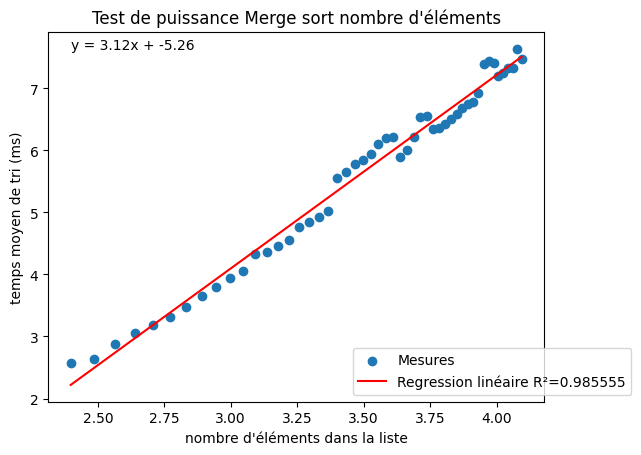

In [ ]:
def dict_from_measures(measures: list[Measure]) -> dict:
    dict = {}
    for measure in measures:
        dict[np.log(measure.size)] = np.log(measure.mean)
    return dict

dict_greedy_sol = dict_from_measures(resultats_greedy)

test_de_puissance(dict_greedy_sol, "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de puissance Merge sort nombre d'éléments")

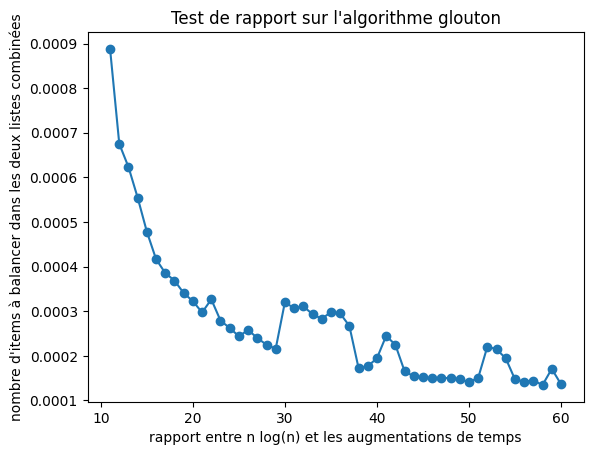

In [ ]:
import math
def change_to_predict(measures: list[Measure], hypothesis = lambda x: x) -> dict:
    new_dict = {}
    for key in measures:
        new_dict[key.size] = key.mean/hypothesis(key.size)
    return new_dict

test_de_rapport(change_to_predict(resultats_greedy, lambda x: x**4), "rapport entre n log(n) et les augmentations de temps", "nombre d'items à balancer dans les deux listes combinées" , "Test de rapport sur l'algorithme glouton")

### Amélioration locale

In [108]:

def main_amelioration(sample):
    start_time = time.time()
    max_time = 60 * 3 - 1
    n = len(sample)
    target = 500 * n
    counties = set_counties(sample)
    print('initial solution')
    sol, groups = max_to_target(counties, target, n)
    if (time.time() - start_time) > max_time:
        return sol
    print("--- %s seconds for solution baseline ---" % (time.time() - start_time))

    #print('vote score: ', votes_score(sample, sol))
    #print('size score: ', size_score(sol))
    #print('distance score: ', distance_score(sol))
    #print('intial score: ',score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    first_iter = True
    iter_time = time.time()
    time_to_iter = 0
    updated = amelioration_locale(groups, target, n, sample, sol)
    sol = updated
    return sol

In [ ]:
resultats_am_locale = measure_range(main_amelioration, problems)

display_data_as_table(resultats_am_locale)

initial solution


100%|██████████| 11/11 [00:00<00:00, 5326.41it/s]


--- 0.007167816162109375 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 4881.74it/s]


--- 0.005638837814331055 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 10917.50it/s]


--- 0.0068056583404541016 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 3654.15it/s]


--- 0.00721430778503418 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 5475.59it/s]


--- 0.005861759185791016 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 10979.85it/s]


--- 0.005044698715209961 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 4415.06it/s]


--- 0.006101846694946289 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 5475.59it/s]


--- 0.006311655044555664 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 8662.66it/s]


--- 0.005331516265869141 seconds for solution baseline ---
initial solution


100%|██████████| 11/11 [00:00<00:00, 5507.62it/s]


--- 0.004011869430541992 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 3661.82it/s]


--- 0.0062787532806396484 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 8507.72it/s]


--- 0.0031518936157226562 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 11887.49it/s]


--- 0.0060694217681884766 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<?, ?it/s]


--- 0.0030660629272460938 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 4782.56it/s]

--- 0.009435415267944336 seconds for solution baseline ---


initial solution


100%|██████████| 12/12 [00:00<00:00, 7172.82it/s]


--- 0.16295218467712402 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 7893.92it/s]


--- 0.005422353744506836 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 10547.29it/s]


--- 0.004674673080444336 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 6011.90it/s]


--- 0.004933357238769531 seconds for solution baseline ---
initial solution


100%|██████████| 12/12 [00:00<00:00, 6578.44it/s]


--- 0.0070455074310302734 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 8255.25it/s]


--- 0.006324052810668945 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6341.70it/s]


--- 0.006476879119873047 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 6438.30it/s]


--- 0.004969596862792969 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 3775.77it/s]


--- 0.005002021789550781 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 8134.56it/s]


--- 0.005056858062744141 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4251.20it/s]


--- 0.006767749786376953 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4303.21it/s]


--- 0.0067348480224609375 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4324.71it/s]


--- 0.005654573440551758 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4321.97it/s]


--- 0.005080699920654297 seconds for solution baseline ---
initial solution


100%|██████████| 13/13 [00:00<00:00, 4323.00it/s]


--- 0.005231380462646484 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 9072.97it/s]


--- 0.003274679183959961 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 3577.01it/s]


--- 0.006087541580200195 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 4631.67it/s]


--- 0.00998067855834961 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 7957.75it/s]


--- 0.006356239318847656 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<?, ?it/s]


--- 0.004344940185546875 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 4023.59it/s]


--- 0.01044464111328125 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 14960.57it/s]


--- 0.0043506622314453125 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 6393.06it/s]


--- 0.009407520294189453 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 8044.97it/s]


--- 0.005756378173828125 seconds for solution baseline ---
initial solution


100%|██████████| 14/14 [00:00<00:00, 9149.31it/s]


--- 0.008318662643432617 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4999.17it/s]


--- 0.0075070858001708984 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 1984.31it/s]

--- 0.008815765380859375 seconds for solution baseline ---
initial solution



100%|██████████| 15/15 [00:00<00:00, 19293.03it/s]


--- 0.0036690235137939453 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 11625.01it/s]


--- 0.004630565643310547 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 3238.68it/s]


--- 0.007807254791259766 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 3101.99it/s]


--- 0.004835605621337891 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4308.33it/s]

--- 0.006871700286865234 seconds for solution baseline ---
initial solution



100%|██████████| 15/15 [00:00<00:00, 3260.84it/s]


--- 0.005429267883300781 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4260.77it/s]


--- 0.005803823471069336 seconds for solution baseline ---
initial solution


100%|██████████| 15/15 [00:00<00:00, 4154.15it/s]


--- 0.008516073226928711 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 4451.08it/s]


--- 0.00804448127746582 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 6639.18it/s]


--- 0.007653713226318359 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<?, ?it/s]


--- 0.011147737503051758 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 4156.89it/s]


--- 0.007581949234008789 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 7975.86it/s]


--- 0.007111072540283203 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3350.25it/s]


--- 0.00838470458984375 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3780.36it/s]


--- 0.010303497314453125 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 2195.61it/s]


--- 0.015333890914916992 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3870.40it/s]


--- 0.008145809173583984 seconds for solution baseline ---
initial solution


100%|██████████| 16/16 [00:00<00:00, 3382.67it/s]


--- 0.012042760848999023 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 2677.25it/s]


--- 0.008793354034423828 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<?, ?it/s]


--- 0.006944894790649414 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 2742.43it/s]


--- 0.008609533309936523 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 4221.87it/s]


--- 0.007846355438232422 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3496.28it/s]


--- 0.006898641586303711 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 5024.89it/s]


--- 0.010129213333129883 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 12222.00it/s]


--- 0.01287078857421875 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 3005.28it/s]


--- 0.006844758987426758 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<00:00, 1904.21it/s]


--- 0.010266304016113281 seconds for solution baseline ---
initial solution


100%|██████████| 17/17 [00:00<?, ?it/s]


--- 0.010166406631469727 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 6949.97it/s]


--- 0.006351470947265625 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3672.59it/s]


--- 0.008497953414916992 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3675.27it/s]


--- 0.012482881546020508 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3469.39it/s]


--- 0.01182413101196289 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3136.58it/s]


--- 0.013317346572875977 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3657.82it/s]


--- 0.012389659881591797 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 5559.05it/s]


--- 0.0121002197265625 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 4681.43it/s]


--- 0.009227275848388672 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 4115.20it/s]


--- 0.008719444274902344 seconds for solution baseline ---
initial solution


100%|██████████| 18/18 [00:00<00:00, 3910.37it/s]


--- 0.009441852569580078 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2778.17it/s]


--- 0.009424686431884766 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 3213.90it/s]


--- 0.01043081283569336 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2668.85it/s]


--- 0.011187076568603516 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2646.86it/s]


--- 0.012144804000854492 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2827.96it/s]


--- 0.01346898078918457 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2928.01it/s]


--- 0.014471054077148438 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2659.76it/s]


--- 0.009966135025024414 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 7865.35it/s]


--- 0.009398460388183594 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 2208.94it/s]


--- 0.00860142707824707 seconds for solution baseline ---
initial solution


100%|██████████| 19/19 [00:00<00:00, 6596.46it/s]


--- 0.006426095962524414 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2217.10it/s]


--- 0.014181375503540039 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 4138.03it/s]


--- 0.011707544326782227 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2390.73it/s]


--- 0.013337135314941406 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 1734.72it/s]


--- 0.014516115188598633 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2953.74it/s]


--- 0.01003122329711914 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 3259.99it/s]


--- 0.0181124210357666 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 1829.94it/s]


--- 0.020442962646484375 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2072.64it/s]


--- 0.01506495475769043 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 2420.05it/s]


--- 0.014150381088256836 seconds for solution baseline ---
initial solution


100%|██████████| 20/20 [00:00<00:00, 1536.35it/s]


--- 0.016924381256103516 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 1787.67it/s]


--- 0.01726365089416504 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2556.31it/s]


--- 0.013619184494018555 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2793.10it/s]


--- 0.012218952178955078 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2510.84it/s]


--- 0.014472246170043945 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2751.05it/s]


--- 0.011058807373046875 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2378.56it/s]


--- 0.014009237289428711 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2561.44it/s]


--- 0.01506185531616211 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2581.56it/s]

--- 0.011921405792236328 seconds for solution baseline ---
initial solution



100%|██████████| 21/21 [00:00<00:00, 2326.17it/s]


--- 0.01813817024230957 seconds for solution baseline ---
initial solution


100%|██████████| 21/21 [00:00<00:00, 2301.73it/s]


--- 0.01421499252319336 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2382.88it/s]


--- 0.015274524688720703 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 1948.12it/s]


--- 0.016285181045532227 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 1646.67it/s]


--- 0.01848602294921875 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2081.45it/s]


--- 0.023077011108398438 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 3349.48it/s]


--- 0.012660026550292969 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 2748.07it/s]


--- 0.020815610885620117 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 3299.06it/s]


--- 0.018046140670776367 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 3949.27it/s]


--- 0.015530109405517578 seconds for solution baseline ---
initial solution


100%|██████████| 22/22 [00:00<00:00, 1838.80it/s]

--- 0.014801025390625 seconds for solution baseline ---
initial solution



100%|██████████| 22/22 [00:00<00:00, 2036.43it/s]


--- 0.015776395797729492 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 2102.00it/s]

--- 0.018674135208129883 seconds for solution baseline ---
initial solution



100%|██████████| 23/23 [00:00<00:00, 1803.87it/s]


--- 0.018616437911987305 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 1161.54it/s]


--- 0.021915912628173828 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 1392.43it/s]


--- 0.027683258056640625 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 1327.48it/s]


--- 0.023752689361572266 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 1687.17it/s]


--- 0.021554231643676758 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 1657.86it/s]


--- 0.01678919792175293 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 1369.27it/s]


--- 0.025173664093017578 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 1488.76it/s]


--- 0.0191195011138916 seconds for solution baseline ---
initial solution


100%|██████████| 23/23 [00:00<00:00, 4887.72it/s]


--- 0.010587692260742188 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 2719.89it/s]


--- 0.014804601669311523 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1848.86it/s]


--- 0.020930767059326172 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1340.21it/s]


--- 0.01790761947631836 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 47572.45it/s]

--- 0.007628440856933594 seconds for solution baseline ---
initial solution



100%|██████████| 24/24 [00:00<00:00, 2129.99it/s]


--- 0.021952390670776367 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1921.50it/s]


--- 0.018230199813842773 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1997.72it/s]


--- 0.016564130783081055 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1804.23it/s]


--- 0.01960611343383789 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1541.34it/s]


--- 0.020173311233520508 seconds for solution baseline ---
initial solution


100%|██████████| 24/24 [00:00<00:00, 1905.24it/s]


--- 0.018901824951171875 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1203.93it/s]


--- 0.022465229034423828 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1334.30it/s]


--- 0.026694536209106445 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1376.73it/s]


--- 0.019664525985717773 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1448.63it/s]


--- 0.0172576904296875 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 2388.07it/s]


--- 0.02218341827392578 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1701.32it/s]


--- 0.020931720733642578 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1795.05it/s]


--- 0.020705699920654297 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1794.71it/s]


--- 0.022054433822631836 seconds for solution baseline ---
initial solution


100%|██████████| 25/25 [00:00<00:00, 1283.86it/s]

--- 0.02332615852355957 seconds for solution baseline ---
initial solution



100%|██████████| 25/25 [00:00<00:00, 1122.55it/s]


--- 0.026514768600463867 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1497.99it/s]


--- 0.022918224334716797 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1584.37it/s]


--- 0.021697521209716797 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1441.67it/s]


--- 0.02808380126953125 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1764.68it/s]


--- 0.020674943923950195 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1570.38it/s]


--- 0.020490407943725586 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1893.82it/s]


--- 0.020664453506469727 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1667.84it/s]


--- 0.020903587341308594 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1650.98it/s]


--- 0.019980669021606445 seconds for solution baseline ---
initial solution


100%|██████████| 26/26 [00:00<00:00, 1878.62it/s]

--- 0.02643299102783203 seconds for solution baseline ---
initial solution



100%|██████████| 26/26 [00:00<00:00, 1673.06it/s]


--- 0.020359516143798828 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 3408.67it/s]


--- 0.012175321578979492 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 2611.35it/s]

--- 0.020702600479125977 seconds for solution baseline ---
initial solution



100%|██████████| 27/27 [00:00<00:00, 1533.79it/s]


--- 0.022029876708984375 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1261.64it/s]


--- 0.02817988395690918 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 4727.26it/s]


--- 0.01483464241027832 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1850.79it/s]


--- 0.02067732810974121 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1349.57it/s]


--- 0.02868032455444336 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1043.20it/s]


--- 0.026385784149169922 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 1003.32it/s]


--- 0.02834320068359375 seconds for solution baseline ---
initial solution


100%|██████████| 27/27 [00:00<00:00, 2037.76it/s]


--- 0.026315927505493164 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1704.80it/s]


--- 0.02688145637512207 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1520.34it/s]


--- 0.029328107833862305 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1566.27it/s]

--- 0.026980876922607422 seconds for solution baseline ---
initial solution



100%|██████████| 28/28 [00:00<00:00, 2026.34it/s]

--- 0.027225494384765625 seconds for solution baseline ---
initial solution



100%|██████████| 28/28 [00:00<00:00, 1818.98it/s]


--- 0.021030426025390625 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1601.71it/s]


--- 0.030398130416870117 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 3456.98it/s]


--- 0.015743017196655273 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 997.97it/s]


--- 0.028565645217895508 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1042.18it/s]


--- 0.02787637710571289 seconds for solution baseline ---
initial solution


100%|██████████| 28/28 [00:00<00:00, 1520.44it/s]


--- 0.023793935775756836 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1209.12it/s]


--- 0.03191637992858887 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1094.39it/s]


--- 0.03282952308654785 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1233.73it/s]


--- 0.03475189208984375 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1266.15it/s]


--- 0.029060840606689453 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1314.90it/s]


--- 0.027332782745361328 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1298.28it/s]


--- 0.02887129783630371 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 981.42it/s]


--- 0.03647255897521973 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1215.28it/s]


--- 0.03003716468811035 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1028.58it/s]


--- 0.029187917709350586 seconds for solution baseline ---
initial solution


100%|██████████| 29/29 [00:00<00:00, 1464.21it/s]


--- 0.02565622329711914 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 716.53it/s]


--- 0.04186820983886719 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1084.11it/s]


--- 0.03471660614013672 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1206.97it/s]

--- 0.0318455696105957 seconds for solution baseline ---


initial solution


100%|██████████| 30/30 [00:00<00:00, 1203.58it/s]


--- 0.03242135047912598 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1273.42it/s]


--- 0.038736820220947266 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1154.79it/s]


--- 0.034737348556518555 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1338.19it/s]


--- 0.03824019432067871 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 966.62it/s]


--- 0.031035900115966797 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 1307.18it/s]


--- 0.030545949935913086 seconds for solution baseline ---
initial solution


100%|██████████| 30/30 [00:00<00:00, 2506.26it/s]


--- 0.01701521873474121 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1507.94it/s]


--- 0.03056478500366211 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 929.95it/s]


--- 0.033334970474243164 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1132.77it/s]


--- 0.03863120079040527 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 749.86it/s]


--- 0.04199385643005371 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1007.86it/s]


--- 0.03920602798461914 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1177.75it/s]

--- 0.03553366661071777 seconds for solution baseline ---


initial solution


100%|██████████| 31/31 [00:00<00:00, 992.32it/s]


--- 0.04051709175109863 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1115.79it/s]

--- 0.03136277198791504 seconds for solution baseline ---
initial solution



100%|██████████| 31/31 [00:00<00:00, 891.13it/s]


--- 0.03478741645812988 seconds for solution baseline ---
initial solution


100%|██████████| 31/31 [00:00<00:00, 1093.88it/s]


--- 0.034844398498535156 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1082.98it/s]


--- 0.04828667640686035 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1443.62it/s]


--- 0.033111572265625 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 780.77it/s]


--- 0.040985107421875 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 716.54it/s]


--- 0.04465889930725098 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1061.72it/s]


--- 0.03685712814331055 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1115.83it/s]


--- 0.034523725509643555 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1032.20it/s]


--- 0.03949451446533203 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 767.43it/s]


--- 0.04285478591918945 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 1088.97it/s]


--- 0.03474068641662598 seconds for solution baseline ---
initial solution


100%|██████████| 32/32 [00:00<00:00, 976.14it/s]


--- 0.03945732116699219 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 962.50it/s]


--- 0.04157447814941406 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 949.93it/s]


--- 0.04329109191894531 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 766.10it/s]


--- 0.05253171920776367 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 942.75it/s]

--- 0.04023885726928711 seconds for solution baseline ---


initial solution


100%|██████████| 33/33 [00:00<00:00, 1049.06it/s]


--- 0.041124820709228516 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 923.04it/s]


--- 0.044651031494140625 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 778.81it/s]


--- 0.04433035850524902 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 922.32it/s]


--- 0.04161262512207031 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 977.27it/s]


--- 0.04178643226623535 seconds for solution baseline ---
initial solution


100%|██████████| 33/33 [00:00<00:00, 980.68it/s]


--- 0.04849362373352051 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 960.51it/s]


--- 0.041864871978759766 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 856.33it/s]


--- 0.04591107368469238 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 930.74it/s]


--- 0.04181861877441406 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 890.71it/s]


--- 0.04737210273742676 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 815.57it/s]


--- 0.049173593521118164 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 841.09it/s]


--- 0.048673391342163086 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 892.79it/s]


--- 0.04497098922729492 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 945.26it/s]


--- 0.044175148010253906 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 991.93it/s]


--- 0.04868507385253906 seconds for solution baseline ---
initial solution


100%|██████████| 34/34 [00:00<00:00, 903.40it/s]


--- 0.04713273048400879 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 757.52it/s]


--- 0.05361747741699219 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 888.41it/s]


--- 0.04440569877624512 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 713.76it/s]


--- 0.05606818199157715 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 962.11it/s]


--- 0.04708051681518555 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 976.61it/s]


--- 0.04771876335144043 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 1090.64it/s]


--- 0.03872251510620117 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 886.16it/s]

--- 0.04693007469177246 seconds for solution baseline ---
initial solution



100%|██████████| 35/35 [00:00<00:00, 821.96it/s]


--- 0.04996132850646973 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 713.25it/s]


--- 0.05457615852355957 seconds for solution baseline ---
initial solution


100%|██████████| 35/35 [00:00<00:00, 677.93it/s]


--- 0.06563472747802734 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 683.34it/s]


--- 0.06587791442871094 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 533.97it/s]


--- 0.30930042266845703 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 986.74it/s]


--- 0.043799638748168945 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 842.89it/s]


--- 0.05582404136657715 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 704.79it/s]


--- 0.06673264503479004 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 799.03it/s]


--- 0.05214047431945801 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 832.84it/s]


--- 0.05009102821350098 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 852.80it/s]


--- 0.05391120910644531 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 746.89it/s]


--- 0.04870271682739258 seconds for solution baseline ---
initial solution


100%|██████████| 36/36 [00:00<00:00, 740.35it/s]


--- 0.05566048622131348 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 768.66it/s]


--- 0.05638885498046875 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 752.49it/s]


--- 0.05739235877990723 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 789.61it/s]


--- 0.05361294746398926 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 655.11it/s]


--- 0.059484004974365234 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 921.63it/s]


--- 0.050154685974121094 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 816.59it/s]


--- 0.05257534980773926 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 798.64it/s]


--- 0.05371809005737305 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 887.65it/s]


--- 0.054889678955078125 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 871.93it/s]


--- 0.04947495460510254 seconds for solution baseline ---
initial solution


100%|██████████| 37/37 [00:00<00:00, 727.52it/s]

--- 0.054796457290649414 seconds for solution baseline ---


initial solution


100%|██████████| 38/38 [00:00<00:00, 741.31it/s]


--- 0.05205273628234863 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 738.64it/s]


--- 0.05789613723754883 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 675.12it/s]


--- 0.06332039833068848 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 683.00it/s]


--- 0.05714678764343262 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 676.34it/s]


--- 0.07343673706054688 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 676.29it/s]


--- 0.06483912467956543 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 585.76it/s]


--- 0.07480931282043457 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 671.62it/s]


--- 0.062012434005737305 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 632.27it/s]


--- 0.07166409492492676 seconds for solution baseline ---
initial solution


100%|██████████| 38/38 [00:00<00:00, 798.18it/s]


--- 0.059810638427734375 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 616.69it/s]


--- 0.07074689865112305 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 526.66it/s]

--- 0.0740511417388916 seconds for solution baseline ---


initial solution


100%|██████████| 39/39 [00:00<00:00, 578.88it/s]


--- 0.06737136840820312 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 780.50it/s]


--- 0.04996776580810547 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 644.47it/s]


--- 0.06620454788208008 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 715.96it/s]


--- 0.06890392303466797 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 800.86it/s]


--- 0.05553460121154785 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 555.20it/s]


--- 0.07024526596069336 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 702.29it/s]


--- 0.06008791923522949 seconds for solution baseline ---
initial solution


100%|██████████| 39/39 [00:00<00:00, 714.61it/s]


--- 0.07008242607116699 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 613.23it/s]


--- 0.07263493537902832 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 645.42it/s]


--- 0.07431960105895996 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 676.44it/s]


--- 0.06940674781799316 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 612.84it/s]

--- 0.06526994705200195 seconds for solution baseline ---
initial solution



100%|██████████| 40/40 [00:00<00:00, 664.97it/s]

--- 0.06866192817687988 seconds for solution baseline ---


initial solution


100%|██████████| 40/40 [00:00<00:00, 647.03it/s]


--- 0.07033157348632812 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 572.94it/s]


--- 0.06981563568115234 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 678.82it/s]


--- 0.06820321083068848 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 518.26it/s]


--- 0.08300518989562988 seconds for solution baseline ---
initial solution


100%|██████████| 40/40 [00:00<00:00, 599.22it/s]


--- 0.08338069915771484 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 551.45it/s]


--- 0.08987832069396973 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 631.90it/s]


--- 0.06538653373718262 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 465.64it/s]


--- 0.10049796104431152 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 350.89it/s]


--- 0.13277626037597656 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 351.33it/s]


--- 0.12972092628479004 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 301.48it/s]


--- 0.14920473098754883 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 340.03it/s]


--- 0.13264989852905273 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 349.64it/s]


--- 0.12814092636108398 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 353.58it/s]


--- 0.2761673927307129 seconds for solution baseline ---
initial solution


100%|██████████| 41/41 [00:00<00:00, 344.42it/s]


--- 0.13066649436950684 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 319.77it/s]


--- 0.1451728343963623 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 310.78it/s]


--- 0.14568424224853516 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 339.95it/s]


--- 0.13755249977111816 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 307.50it/s]


--- 0.14925074577331543 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 330.02it/s]


--- 0.1389167308807373 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 328.70it/s]

--- 0.144456148147583 seconds for solution baseline ---
initial solution



100%|██████████| 42/42 [00:00<00:00, 318.50it/s]


--- 0.14448761940002441 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 308.79it/s]


--- 0.15124773979187012 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 344.06it/s]


--- 0.13623261451721191 seconds for solution baseline ---
initial solution


100%|██████████| 42/42 [00:00<00:00, 374.14it/s]


--- 0.12494564056396484 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 304.54it/s]


--- 0.1553173065185547 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 331.16it/s]


--- 0.14255714416503906 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 305.64it/s]

--- 0.1547224521636963 seconds for solution baseline ---


initial solution


100%|██████████| 43/43 [00:00<00:00, 314.86it/s]

--- 0.14917778968811035 seconds for solution baseline ---


initial solution


100%|██████████| 43/43 [00:00<00:00, 299.54it/s]


--- 0.1580796241760254 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 297.10it/s]

--- 0.1568160057067871 seconds for solution baseline ---
initial solution



100%|██████████| 43/43 [00:00<00:00, 321.03it/s]


--- 0.14713406562805176 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 300.69it/s]


--- 0.15716123580932617 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 304.22it/s]


--- 0.1525571346282959 seconds for solution baseline ---
initial solution


100%|██████████| 43/43 [00:00<00:00, 347.11it/s]


--- 0.13774704933166504 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 305.53it/s]


--- 0.1588597297668457 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 261.53it/s]


--- 0.1821269989013672 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 298.82it/s]

--- 0.16024518013000488 seconds for solution baseline ---


initial solution


100%|██████████| 44/44 [00:00<00:00, 278.47it/s]


--- 0.17234396934509277 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 301.19it/s]


--- 0.159379243850708 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 291.69it/s]


--- 0.16483712196350098 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 310.52it/s]


--- 0.1538376808166504 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 299.13it/s]

--- 0.15952086448669434 seconds for solution baseline ---


initial solution


100%|██████████| 44/44 [00:00<00:00, 324.21it/s]


--- 0.1497185230255127 seconds for solution baseline ---
initial solution


100%|██████████| 44/44 [00:00<00:00, 314.23it/s]


--- 0.15324807167053223 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 299.48it/s]

--- 0.1655564308166504 seconds for solution baseline ---


initial solution


100%|██████████| 45/45 [00:00<00:00, 297.58it/s]

--- 0.16483235359191895 seconds for solution baseline ---


initial solution


100%|██████████| 45/45 [00:00<00:00, 305.60it/s]

--- 0.16176581382751465 seconds for solution baseline ---
initial solution



100%|██████████| 45/45 [00:00<00:00, 280.26it/s]


--- 0.17225360870361328 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 300.85it/s]


--- 0.31583404541015625 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 265.90it/s]


--- 0.18174052238464355 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 268.40it/s]


--- 0.183333158493042 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 296.23it/s]


--- 0.164259672164917 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 283.07it/s]


--- 0.17409920692443848 seconds for solution baseline ---
initial solution


100%|██████████| 45/45 [00:00<00:00, 266.72it/s]


--- 0.18123078346252441 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 263.81it/s]

--- 0.19114112854003906 seconds for solution baseline ---


initial solution


100%|██████████| 46/46 [00:00<00:00, 285.39it/s]

--- 0.1753392219543457 seconds for solution baseline ---


initial solution


100%|██████████| 46/46 [00:00<00:00, 253.76it/s]


--- 0.1963367462158203 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 230.05it/s]


--- 0.21292400360107422 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 277.76it/s]

--- 0.18093085289001465 seconds for solution baseline ---


initial solution


100%|██████████| 46/46 [00:00<00:00, 248.60it/s]


--- 0.19913482666015625 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 281.36it/s]


--- 0.17768168449401855 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 258.07it/s]


--- 0.1922471523284912 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 263.20it/s]


--- 0.1895139217376709 seconds for solution baseline ---
initial solution


100%|██████████| 46/46 [00:00<00:00, 260.28it/s]


--- 0.1913743019104004 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 259.46it/s]


--- 0.1959540843963623 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 255.94it/s]


--- 0.1972975730895996 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 272.89it/s]


--- 0.187391996383667 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 266.21it/s]


--- 0.18979597091674805 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 250.21it/s]


--- 0.2024974822998047 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 250.05it/s]


--- 0.20059704780578613 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 248.25it/s]


--- 0.20448780059814453 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 258.34it/s]


--- 0.19715118408203125 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 255.23it/s]


--- 0.19985103607177734 seconds for solution baseline ---
initial solution


100%|██████████| 47/47 [00:00<00:00, 262.02it/s]


--- 0.19437170028686523 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 260.18it/s]


--- 0.1984999179840088 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 221.33it/s]


--- 0.36890435218811035 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 242.49it/s]


--- 0.21164393424987793 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 213.93it/s]


--- 0.2391819953918457 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 236.04it/s]


--- 0.21636629104614258 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 243.19it/s]

--- 0.21107006072998047 seconds for solution baseline ---


initial solution


100%|██████████| 48/48 [00:00<00:00, 234.80it/s]


--- 0.21916818618774414 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 241.53it/s]


--- 0.2119126319885254 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 234.17it/s]


--- 0.21998286247253418 seconds for solution baseline ---
initial solution


100%|██████████| 48/48 [00:00<00:00, 202.42it/s]


--- 0.25935959815979004 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 211.82it/s]


--- 0.24746441841125488 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 215.14it/s]


--- 0.24344325065612793 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 223.20it/s]


--- 0.23382210731506348 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 200.40it/s]


--- 0.26153111457824707 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 221.25it/s]


--- 0.23511672019958496 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 219.05it/s]


--- 0.24030303955078125 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 195.57it/s]


--- 0.2666971683502197 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 219.80it/s]


--- 0.2368910312652588 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 219.67it/s]


--- 0.23994016647338867 seconds for solution baseline ---
initial solution


100%|██████████| 49/49 [00:00<00:00, 231.06it/s]


--- 0.22622370719909668 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 217.72it/s]


--- 0.24692201614379883 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 236.54it/s]


--- 0.22604131698608398 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 208.46it/s]


--- 0.25448131561279297 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 217.46it/s]


--- 0.3891136646270752 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 226.26it/s]


--- 0.23582148551940918 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 210.15it/s]


--- 0.2549245357513428 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 210.69it/s]


--- 0.2538270950317383 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 218.97it/s]


--- 0.2444782257080078 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 199.91it/s]


--- 0.26807069778442383 seconds for solution baseline ---
initial solution


100%|██████████| 50/50 [00:00<00:00, 217.30it/s]


--- 0.24521398544311523 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 179.44it/s]


--- 0.3002321720123291 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 202.83it/s]


--- 0.26721668243408203 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 195.68it/s]


--- 0.2763679027557373 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 211.52it/s]


--- 0.2552335262298584 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 204.81it/s]


--- 0.2661447525024414 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 204.82it/s]


--- 0.26445627212524414 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 207.23it/s]


--- 0.26250791549682617 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 190.89it/s]


--- 0.283463716506958 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 193.14it/s]


--- 0.2805659770965576 seconds for solution baseline ---
initial solution


100%|██████████| 51/51 [00:00<00:00, 207.42it/s]


--- 0.26276087760925293 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 169.20it/s]


--- 0.32433462142944336 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 184.34it/s]


--- 0.2977278232574463 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 199.64it/s]


--- 0.42899465560913086 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 179.35it/s]


--- 0.3052840232849121 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 187.06it/s]


--- 0.29499220848083496 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 184.72it/s]


--- 0.2971956729888916 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 189.50it/s]


--- 0.2914161682128906 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 185.76it/s]


--- 0.2969367504119873 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 184.94it/s]


--- 0.29618000984191895 seconds for solution baseline ---
initial solution


100%|██████████| 52/52 [00:00<00:00, 190.93it/s]


--- 0.29051709175109863 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 176.56it/s]


--- 0.31805896759033203 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 167.66it/s]


--- 0.33296823501586914 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 188.83it/s]


--- 0.2977485656738281 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 175.02it/s]


--- 0.32070374488830566 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 177.32it/s]


--- 0.31825757026672363 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 195.97it/s]


--- 0.2870657444000244 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 178.56it/s]


--- 0.31281471252441406 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 173.74it/s]


--- 0.4651937484741211 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 175.69it/s]


--- 0.31839776039123535 seconds for solution baseline ---
initial solution


100%|██████████| 53/53 [00:00<00:00, 166.63it/s]


--- 0.3335866928100586 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 176.26it/s]


--- 0.3219630718231201 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 184.48it/s]


--- 0.31246066093444824 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 163.11it/s]


--- 0.3480794429779053 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 171.20it/s]


--- 0.33321690559387207 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 185.02it/s]


--- 0.31052565574645996 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 166.97it/s]


--- 0.3425469398498535 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 174.31it/s]


--- 0.32779407501220703 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 170.18it/s]


--- 0.3345210552215576 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 173.63it/s]


--- 0.3275105953216553 seconds for solution baseline ---
initial solution


100%|██████████| 54/54 [00:00<00:00, 165.17it/s]


--- 0.3459475040435791 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 150.15it/s]


--- 0.38629627227783203 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 170.57it/s]


--- 0.4863739013671875 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 163.70it/s]


--- 0.35390353202819824 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 169.23it/s]


--- 0.3417079448699951 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 163.41it/s]


--- 0.35349130630493164 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 162.91it/s]


--- 0.3550994396209717 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 167.20it/s]


--- 0.34856653213500977 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 163.05it/s]


--- 0.3557107448577881 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 155.95it/s]


--- 0.3722386360168457 seconds for solution baseline ---
initial solution


100%|██████████| 55/55 [00:00<00:00, 174.10it/s]


--- 0.33411407470703125 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 166.53it/s]


--- 0.35417938232421875 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 140.57it/s]


--- 0.416027307510376 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 127.15it/s]


--- 0.4612734317779541 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 136.79it/s]


--- 0.4332871437072754 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 138.70it/s]


--- 0.6059348583221436 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 157.96it/s]


--- 0.37947916984558105 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 120.62it/s]


--- 0.4855659008026123 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 103.27it/s]


--- 0.5605883598327637 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 122.97it/s]


--- 0.47775959968566895 seconds for solution baseline ---
initial solution


100%|██████████| 56/56 [00:00<00:00, 145.08it/s]


--- 0.4048495292663574 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 146.66it/s]


--- 0.41004061698913574 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 231.47it/s]


--- 0.2587559223175049 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 237.98it/s]


--- 0.25302624702453613 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 236.52it/s]


--- 0.254685640335083 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 223.56it/s]


--- 0.26755571365356445 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 244.18it/s]


--- 0.24618029594421387 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 141.14it/s]


--- 0.4160020351409912 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 215.42it/s]


--- 0.2763490676879883 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 223.25it/s]


--- 0.26801633834838867 seconds for solution baseline ---
initial solution


100%|██████████| 57/57 [00:00<00:00, 227.11it/s]


--- 0.2635338306427002 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 210.10it/s]


--- 0.29187512397766113 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 198.37it/s]


--- 0.3072521686553955 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 193.95it/s]


--- 0.3124675750732422 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 213.68it/s]


--- 0.28600287437438965 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 178.25it/s]


--- 0.33950376510620117 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 177.44it/s]


--- 0.3420708179473877 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 218.65it/s]


--- 0.2777869701385498 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 211.72it/s]


--- 0.2892277240753174 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 200.13it/s]


--- 0.30612969398498535 seconds for solution baseline ---
initial solution


100%|██████████| 58/58 [00:00<00:00, 203.80it/s]


--- 0.46424388885498047 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 203.24it/s]


--- 0.30297422409057617 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 192.10it/s]


--- 0.3197946548461914 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 210.84it/s]


--- 0.2925140857696533 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 211.20it/s]


--- 0.29215502738952637 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 207.45it/s]


--- 0.2956063747406006 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 213.93it/s]


--- 0.2896735668182373 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 231.64it/s]


--- 0.268373966217041 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 206.93it/s]


--- 0.2963435649871826 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 209.84it/s]


--- 0.29255151748657227 seconds for solution baseline ---
initial solution


100%|██████████| 59/59 [00:00<00:00, 145.15it/s]


--- 0.420426607131958 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 195.87it/s]


--- 0.3211824893951416 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 198.82it/s]


--- 0.3150660991668701 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 222.89it/s]


--- 0.28139448165893555 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 193.77it/s]


--- 0.3241548538208008 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 183.22it/s]


--- 0.3395266532897949 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 202.36it/s]


--- 0.31162238121032715 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 156.56it/s]


--- 0.39874863624572754 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 195.90it/s]


--- 0.31970977783203125 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 194.88it/s]


--- 0.3209190368652344 seconds for solution baseline ---
initial solution


100%|██████████| 60/60 [00:00<00:00, 163.85it/s]

--- 0.37833237648010254 seconds for solution baseline ---
Taille       Temps moyen  Score moyen 
11           6.4          289.6545454545454
12           21.3         422.7333333333333
13           6.1          496.42307692307696
14           6.8          801.8785714285715
15           7.0          864.8399999999999
16           9.9          1219.61875  
17           9.5          1240.7      
18           10.9         1521.3666666666666
19           11.8         1877.9894736842107
20           17.0         2093.395    
21           15.1         2248.7904761904765
22           18.9         2958.759090909091
23           21.4         2702.769565217391
24           20.0         3637.0458333333336
25           23.3         3730.612    
26           23.7         4124.7      
27           25.2         4618.6925925925925
28           29.7         4260.567857142857
29           32.5         4927.913793103448
30           34.4         5598.88     
31           37.7         5551.583870967742
32 

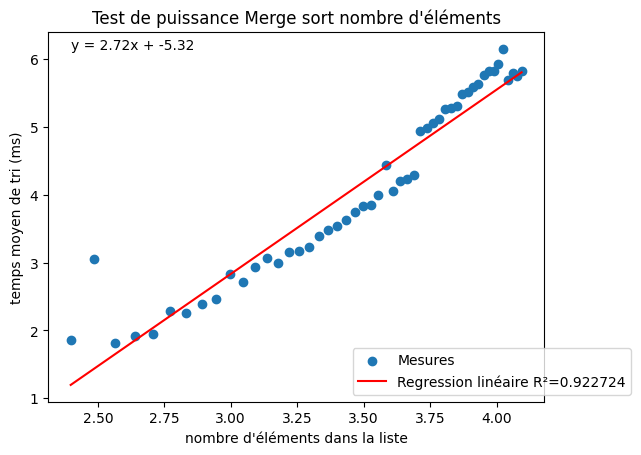

In [110]:
dict_am_locale = dict_from_measures(resultats_am_locale)

test_de_puissance(dict_am_locale, "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de puissance Merge sort nombre d'éléments")

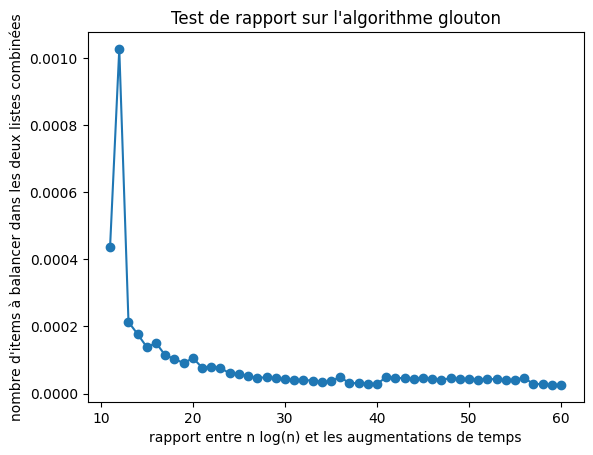

In [111]:
test_de_rapport(change_to_predict(resultats_am_locale, lambda x: x**4), "rapport entre n log(n) et les augmentations de temps", "nombre d'items à balancer dans les deux listes combinées" , "Test de rapport sur l'algorithme glouton")

### Amélioration locale

Ceci était un essaie qui ne fonctionne pas de calculer indépendamment l'amélioration locale

In [102]:
def main_preparation(sample):
    start_time = time.time()
    n = len(sample)
    target = 500 * n
    counties = set_counties(sample)
    sol, groups = max_to_target(counties, target, n)
    return (sol, groups, sample, n, target, counties)
    

In [103]:
problems = make_problems([x for x in range(11, 15)], 10)
resultats_initials = {"solutions_initiales": [],
                       "groupes": [],
                       "samples": [],
                       "ns": [],
                       "targets": [], 
                       "counties": []}
for prob in problems:
    solutions_initiales, groupes, samples, ns, targets, counties = [], [], [], [], [], []
    sols = [main_preparation(sample) for sample in prob.generate_dataset()]
    for sol in sols:
        solutions_initiales.append(sol[0])
        groupes.append(sol[1])
        samples.append(sol[2])
        ns.append(sol[3])
        targets.append(sol[4])
        counties.append(sol[5])
    
    resultats_initials["solutions_initiales"].append(solutions_initiales)
    resultats_initials["groupes"].append(groupes)
    resultats_initials["samples"].append(samples)
    resultats_initials["ns"].append(ns)
    resultats_initials["targets"].append(targets)
    resultats_initials["counties"].append(counties)



100%|██████████| 14/14 [00:00<00:00, 3724.72it/s]


In [ ]:

def main_amelioration(sample):
    start_time = time.time()
    max_time = 60 * 3 - 1
    n = len(sample)
    target = 500 * n
    counties = resultats_initials["counties"]
    print('initial solution')
    sol, groups = max_to_target(counties, target, n)
    if (time.time() - start_time) > max_time:
        return sol
    print("--- %s seconds for solution baseline ---" % (time.time() - start_time))

    #print('vote score: ', votes_score(sample, sol))
    #print('size score: ', size_score(sol))
    #print('distance score: ', distance_score(sol))
    #print('intial score: ',score_solution(sample, sol))
    #drawmap_of_discrits(n, sol)
    first_iter = True
    iter_time = time.time()
    time_to_iter = 0
    print('improvement')
    while(True):
        updated = amelioration_locale(groups, target, n, sample, sol)
        sol = updated

In [96]:
print(resultats_initials["groupes"])

resultats_am_locale = measure(lambda x: amelioration_locale(x["groupes"][0][0], x["targets"][0][0], x["ns"][0][0], x["samples"][0][0], x["solutions_initiales"][0][0]), resultats_initials)

display_data_as_table(resultats_graphs)

[[[[<__main__.County object at 0x00000190972F8D10>, <__main__.County object at 0x00000190972F9430>, <__main__.County object at 0x00000190972F8FB0>, <__main__.County object at 0x00000190972FBE30>, <__main__.County object at 0x00000190972FB200>, <__main__.County object at 0x00000190972FA540>, <__main__.County object at 0x00000190972F86E0>, <__main__.County object at 0x00000190972FA480>, <__main__.County object at 0x00000190972FA840>, <__main__.County object at 0x00000190972FB290>, <__main__.County object at 0x00000190972FB3E0>], [<__main__.County object at 0x00000190972F8830>, <__main__.County object at 0x00000190972F89B0>, <__main__.County object at 0x00000190972FAA20>, <__main__.County object at 0x00000190972FB710>, <__main__.County object at 0x00000190972F9B20>, <__main__.County object at 0x00000190972FA4B0>, <__main__.County object at 0x00000190972FA150>, <__main__.County object at 0x00000190972FB500>, <__main__.County object at 0x00000190972F8650>, <__main__.County object at 0x00000

InvalidSolution: Invalid solution, verify your code.

# Analyse code carbon (2 pts)

Effectuer une anlayse code carbon en sélectionnant différent pays pour l'analyse. Commenter vos résultats.

In [ ]:
from codecarbon import EmissionsTracker
try:
    tracker = EmissionsTracker(measure_power_secs=5, tracking_mode="process")

    tracker.start_task("main")
    # TODO Appel glouton
    results = measure_range(main, make_problems([x for x in range(11, 61)], [5]))
    tracker.stop_task()

finally:
    _ = tracker.stop()

# Conclusion (6 pts)

# Étapes d'amélioration pour arriver à notre version actuelle
Nous avons commencé par un algorithme glouton qui n'avait aucune gestion du temps et aucune amélioration après le passage initial. Cet algorithme était en theta(n³) au lieu de theta(n⁴) comme notre algorithme actuel, car nous faisions une selection  du premier élément d'un groupe de manière complètment aléatoire. De plus, lorsqu'il n'y avait pas de voisins disponibles pour choisir le prochain élément, l'élément choisi dans le groupe était aléatoire ce qui donnait de mauvais scores de distance. De plus, nous n'avions pas encore l'objet County pour nous aider à clarifier le code. Du fait, nos heuristiques de choix de prochain élément étaient très rudimentaires et inefficace. Les score pour n=100 étaient autour de 700 000.

Nous avons par la suite ajouté une section d'amélioration locale. Pour choisir le groupe auquel nous voulions faire une amélioration, nous avons commencé par prendre celui qui a un nombre de vote le plus près d'une majorité et prendre le meilleur des échanges. Par contre, nous avons réalisé que certains des échanges étaient considérés comme sous optimaux et pris quand même. De plus, seulement un groupe recevait des modifications constantes jusqu'à atteindre un nombre de vote majoritaire puis un prochain. Nous avons donc changé notre algorithme pour prendre un groupe aléatoire parmis tous et vérifier que le meilleur échange améliore la situation et sinon ne pas faire d'échange. Ceci nous a permis de ne pas rester pris dans un minimum et presque toujours faire des améliorations avec chaque passage et arrêter seuelement lorsque le score obtenu est excellent.

# Points forts de notre algorithme
Notre algorithme trouve une solution initiale qui est souvent vraiment bonne et satisfaisante, même sans la mise en place d'une amélioration locale. Bref, bien que la complexité soit grande, notre passage initial donne une solution d'environ 25 000 pour n=100.

L'autre force de notre algorithme est que l'amélioration locale améliore rellement le score même après une grande quantité d'améliorations. En effet, le groupe qui reçoit une amélioration est choisi aléatoirement ce qui nous permet de tout améliorer. De plus, si jamais la quantité d'amélioration maximale pour la solution actuelle est atteinte, notre algorithme va préférer ne prendre aucune action plutôt qu'une action sous optimale.

# Points faibles de notre algorithme
Notre algorithme est vraiment lent pour trouver une solution initiale. Bien que la solution soit bonne, elle demande un trop grand temps de calcul pour de grandes valeurs de n. Un autre point faible de notre algorithme est de ne pas prendre avantage du débalancement possible dans les grandeurs des groupes de County. Nous pourrions surement aller chercher des scores plus élevés avec un débalancement faible dans le nombre de County inclus par groupe.

# Amélioration possibles
Pour améliorer notre algorithme, 2 avenues sont à explorer. La première est de fournir une version encore plus rapide de solution initiale pour être correct dans des situations ou le n prend une très très grande valeur. Ainsi je crois qu'il faudrait un système de thread pour faire des interruptions pour s'assurer de ne pas dépasser les temps prévus peu import la technique utilisée. Bien sur, l'utilisation de thread serait aussi très utile pour accélérer les performances et non seulement faire un meilleur timer.

La deuxième amélioration que nous aurions aimé explorer avec plus de temps est d'introduire un débalancement dans le nombre de County par groupe de vote. Ainsi, nous aurions pu réduire le score de groupes gagnés qui devient important avec des grandes valeurs par sa nature quadratique. Pour faire ce débalancement, l'algorithme d'amélioration locale pourrait avoir la capacité de prendre un County au lieu de simplement faire des échanges.

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -2 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.